# "신용카드 사용자 연체 예측 AI 경진대회"의 train 데이터로 군집화 실습 및 마케팅 전략 도출

In [1]:
# 필요한 라이브러리 임포트

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import random, warnings
warnings.filterwarnings("ignore")

# 기본 시각화 라이브러리 임포트
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns 
from matplotlib import rc
rc("font", family="AppleGothic")
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe"
plt.rcParams['axes.unicode_minus'] = False

# 스케일링.. 등
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 데이터 가져오기
train_df = pd.read_csv('/Users/raekkkky/Desktop/DNA/winter 24/project7/train.csv')
train_df.shape

(26457, 20)

In [2]:
train_df['credit'] = train_df['credit'].replace({0: 1, 1: 1})

In [3]:
# [0] occyp_type 결측치 채우기 (살리기)
train_df.dropna(subset=['occyp_type'], inplace=True)

In [4]:
# [1] ID 변수 생성해서 동일 인물 추리기
train_df['ID'] = \
train_df['child_num'].astype(str) + '_' + train_df['income_total'].astype(str) + '_' +\
train_df['DAYS_BIRTH'].astype(str) + '_' + train_df['DAYS_EMPLOYED'].astype(str) + '_' +\
train_df['work_phone'].astype(str) + '_' + train_df['phone'].astype(str) + '_' +\
train_df['email'].astype(str) + '_' + train_df['family_size'].astype(str) + '_' +\
train_df['gender'].astype(str) + '_' + train_df['car'].astype(str) + '_' +\
train_df['reality'].astype(str) + '_' + train_df['income_type'].astype(str) + '_' +\
train_df['edu_type'].astype(str) + '_' + train_df['family_type'].astype(str) + '_' +\
train_df['house_type'].astype(str) + '_' + train_df['occyp_type'].astype(str)

# [2] 인당 카드 발급 개수 변수 추가하기
train_df['credit_card_count'] = train_df.groupby('ID')['ID'].transform('count')

# [3] ID 중복 처리 (동일 인물이라고 판단)
train_df = train_df.drop_duplicates(subset='ID', keep='first')

# [4] 불필요한 ID 변수 삭제
train_df = train_df.drop('ID', axis=1)
train_df.shape

(6078, 21)

In [5]:
# [5] 의미없는 변수 5개 제거
train_df.drop(['index', 'FLAG_MOBIL', 'work_phone', 'phone', 'email'], axis=1, inplace=True)
train_df.shape
# 1. index -> 불필요하므로 삭제
# 2. gender
# 3. car
# 4. reality
# 5. child_num
# 6. income_total
# 7. income_type
# 8. edu_type
# 9. family_type
# 10. house_type
# 11. DAYS_BIRTH
# 12. DAYS_EMPLOYED
# 13. FLAG_MOBIL -> 불필요하므로 삭제
# 14. work_phone -> 불필요하므로 삭제
# 15. phone -> 불필요하므로 삭제
# 16. email -> 불필요하므로 삭제
# 17. occyp_type -> 결측치가 너무 많으므로 삭제하려 했으나, 값들의 중요성을 보고 결측치 행들만 삭제!
# 18. family_size
# 19. begin_month
# 20. credit
# 21. credit_card_count

(6078, 16)

In [6]:
# [6] 이상치 처리(제거)
train_df = train_df[(train_df['family_size'] <= 7)]  # 가족 수가 7 초과인 것들 삭제
train_df = train_df[(train_df['child_num'] <= 5)]  # 자녀 수가 5 초과인 것들 삭제
train_df = train_df.reset_index(drop=True)  # 새롭게 초기화 배열

# [7] 날짜변수 변환 (양수->0 + 음수->양수)
train_df['DAYS_EMPLOYED'] = train_df['DAYS_EMPLOYED'].map(lambda x: 0 if x > 0 else x)
dates = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for date in dates:
    train_df[date] = np.abs(train_df[date])

In [7]:
# [8] 전략 도출에 필요한 파생변수 5개 생성 [참고로 변수선택은 안할거임 (다 필요함)]

# 1. before_EMPLOYED_year : 고용되지 전까지의 년
train_df['before_EMPLOYED_year'] = (train_df['DAYS_BIRTH'] - train_df['DAYS_EMPLOYED']) // 365

# 2. Age : 나이
train_df['Age'] = train_df['DAYS_BIRTH'] // 365
    
# 3. DAYS_BIRTH_month : 태어난 월 (출생연도의 n월)
train_df['DAYS_BIRTH_month'] = np.floor(train_df['DAYS_BIRTH'] / 30) - ((np.floor(train_df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)

# 4. EMPLOYED : 근속연수
train_df['EMPLOYED'] = train_df['DAYS_EMPLOYED'] // 365

# 5. begin_year : 신용카드 발급 년도
train_df['begin_year'] = train_df['begin_month'] // 12

# train_df 인덱스 깔끔하게 초기화
train_df.reset_index(drop=True, inplace=True)
train_df.shape

(6075, 21)

In [8]:
# [9] Numeric, Category 컬럼 분류

numerical_feats = train_df.dtypes[train_df.dtypes != "object"].index.tolist()
categorical_feats = train_df.dtypes[train_df.dtypes == "object"].index.tolist()
print("Number of Numerical features: ", len(numerical_feats))
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  13
Number of Categorical features:  8


In [9]:
# 최종본 ⭐️
train_fin = train_df.copy()

# 군집화 제작 시작
train = train_df.copy()

In [10]:
# [10] 카테고리형 데이터 인코딩 진행 (수치형 변환)

# OrdinalEncoder 가져오고
encoder = OrdinalEncoder(categorical_feats)

# 인코딩 적용 [순서 적용]
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])

# 형변환
train[categorical_feats] = train[categorical_feats].astype('int64')

In [11]:
# [11] 스케일링 (로그변환 미실시)

# 수치형 변수 표준화 (단위 통일)
# 수치형 변수 중 연속형 변수(수입, 날짜)만 표준화를 진행함 (이산형 변수는 표준화를 보통 안함!!)
data = ['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month']
scaler = StandardScaler()
train[data] = scaler.fit_transform(train[data])

# train 인덱스 깔끔하게 초기화
train.shape

(6075, 21)

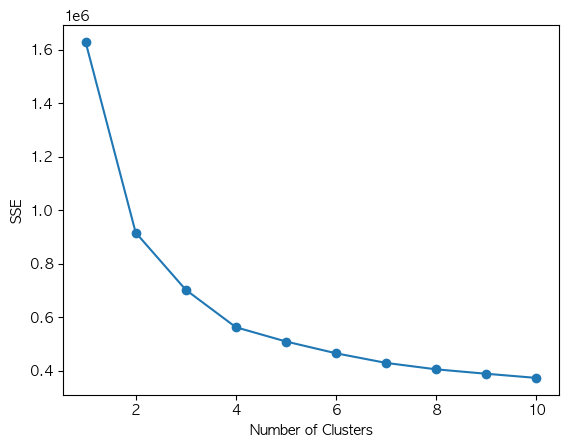

In [12]:
# 군집화 개수 찾기 및 군집 평가하기! (목적변수도 포함해서 진행 - 전략 기획을 위해서!)

# 1. Elbow Method로 K를 구하기!

# SSE 계산을 위한 리스트
sse = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train)
    sse.append(kmeans.inertia_)

# 엘보우 메서드 그래프
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

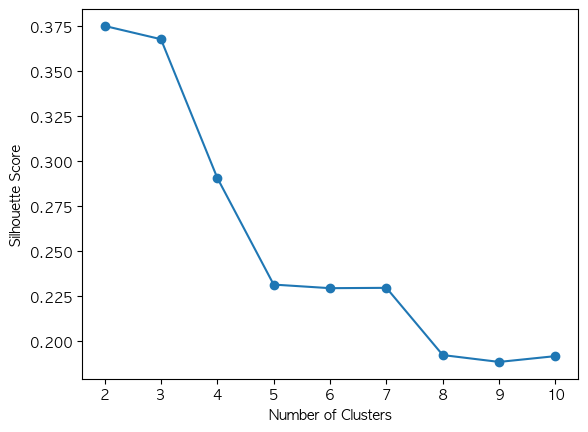

In [13]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train)
    sil_score = silhouette_score(train, kmeans.labels_)
    sil_scores.append(sil_score)

# 실루엣 분석 그래프
plt.plot(range(2, 11), sil_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [14]:
# 차원축소
##### 1. 데이터 형태가 어떻게 되어있을지 시각적으로 확인하기 위해 차원축소 적용 (2, 3차원)
##### 2. PCA를 가장 잘 알고 있기에 설명하기도 편해서 PCA 사용!
##### 3. 최대한 정보의 손실을 줄이기 위해서 정보가 얼마나 줄었는지도 확인하기!

pca = PCA(n_components=2)
pca_result = pca.fit_transform(train)

# PCA 결과를 데이터프레임에 추가
train_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
train_final = pd.concat([train, train_pca], axis=1)

# PCA 주성분별 설명된 분산의 비율 출력
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:")
print("PC1:", explained_variance_ratio[0])
print("PC2:", explained_variance_ratio[1])

Explained Variance Ratio:
PC1: 0.6205457190837382
PC2: 0.2285914986118339


In [15]:
# 2차원 산점도 시각화
import plotly.express as px

fig = px.scatter(train_final, x='PC1', y='PC2')
fig.show()

In [16]:
# 차원축소를 적용한 데이터로 군집화 후 시각화! [2차원 산점도 시각화]

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

# K-means 군집화를 위해 PCA 적용
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train)

# PCA 결과를 데이터프레임에 추가
train_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
train_final = pd.concat([train, train_pca], axis=1)

# K-means 군집화
kmeans = KMeans(n_clusters=4, random_state=42).fit(train_pca[['PC1', 'PC2']])

# 군집 결과를 데이터프레임에 추가
train_final['cluster'] = kmeans.labels_

# K-means 군집 결과 시각화
fig_cluster = px.scatter(train_final, x='PC1', y='PC2', color='cluster', title='K-means Clustering')
fig_cluster.show()

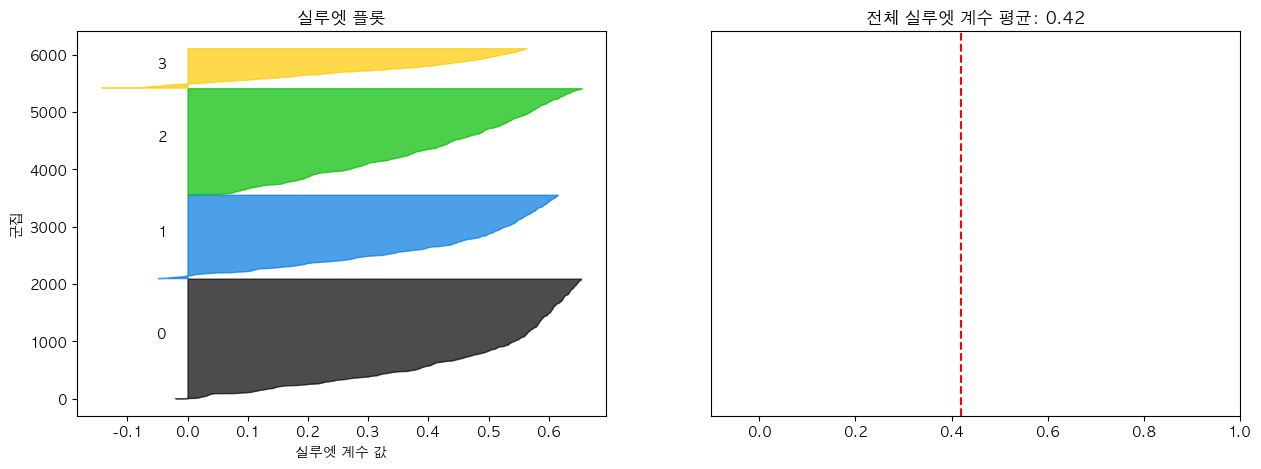

In [17]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# K-means 군집화 결과에 대한 실루엣 계수 계산
silhouette_values = silhouette_samples(train_pca[['PC1', 'PC2']], kmeans.labels_)

# 데이터프레임에 실루엣 계수 추가
train_final['silhouette'] = silhouette_values

# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 실루엣 플롯
y_lower = 10
for i in range(4):  # 군집의 수에 따라 조절
    ith_cluster_silhouette_values = silhouette_values[train_final['cluster'] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / 4)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax1.set_title("실루엣 플롯")
ax1.set_xlabel("실루엣 계수 값")
ax1.set_ylabel("군집")

# 전체 실루엣 계수 평균 플롯
silhouette_avg = silhouette_score(train_pca[['PC1', 'PC2']], kmeans.labels_)
ax2.axvline(x=silhouette_avg, color="red", linestyle="--")
ax2.set_yticks([])  # y 축 레이블 제거
ax2.set_xlim([-0.1, 1])
ax2.set_title("전체 실루엣 계수 평균: {:.2f}".format(silhouette_avg))

plt.show()

In [18]:
# 최종 시각화할 데이터프레임
train_fin = pd.concat([train_fin, train_final['cluster']], axis=1)

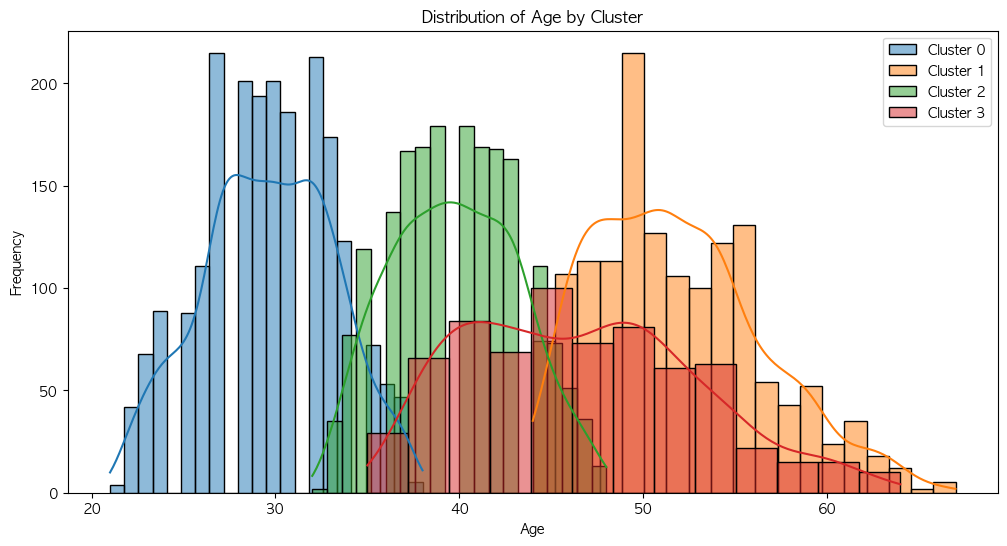

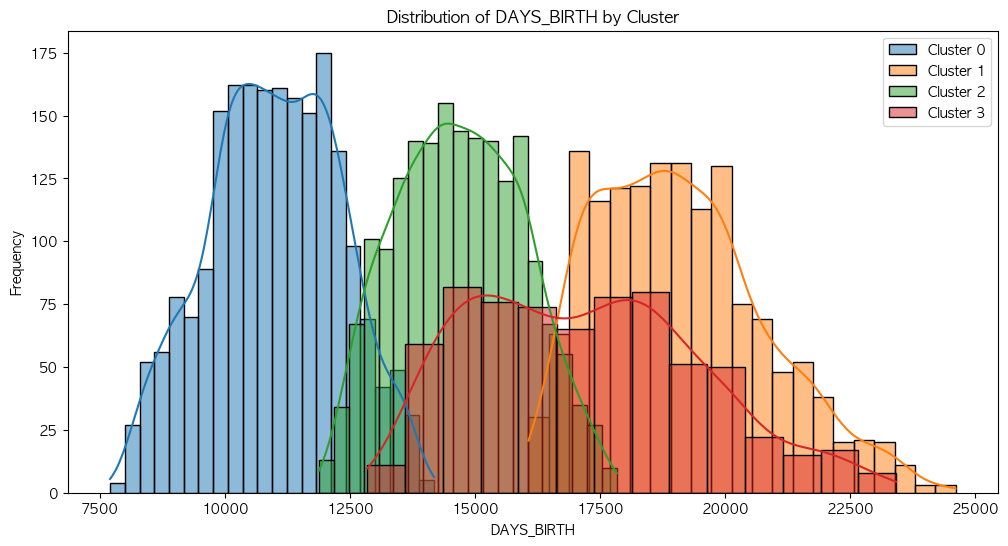

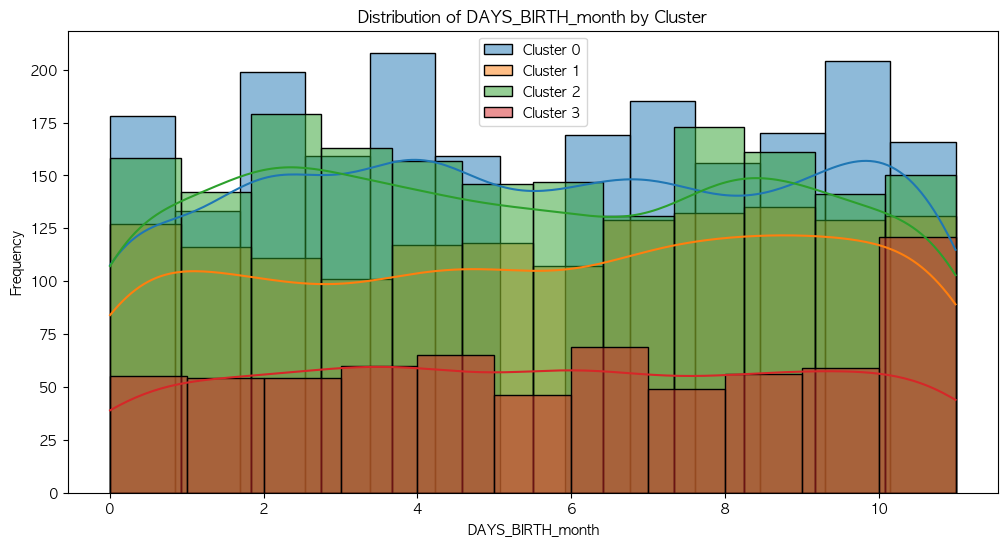

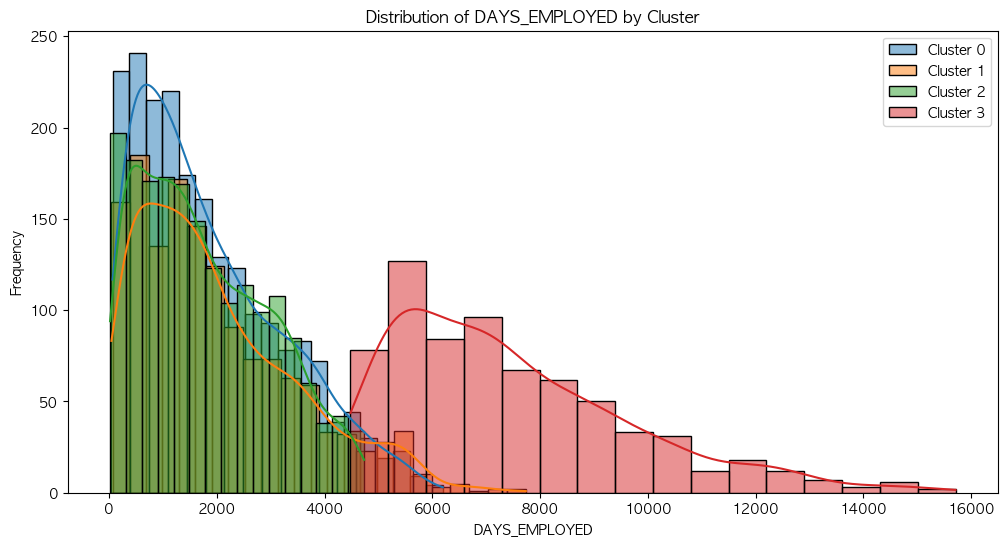

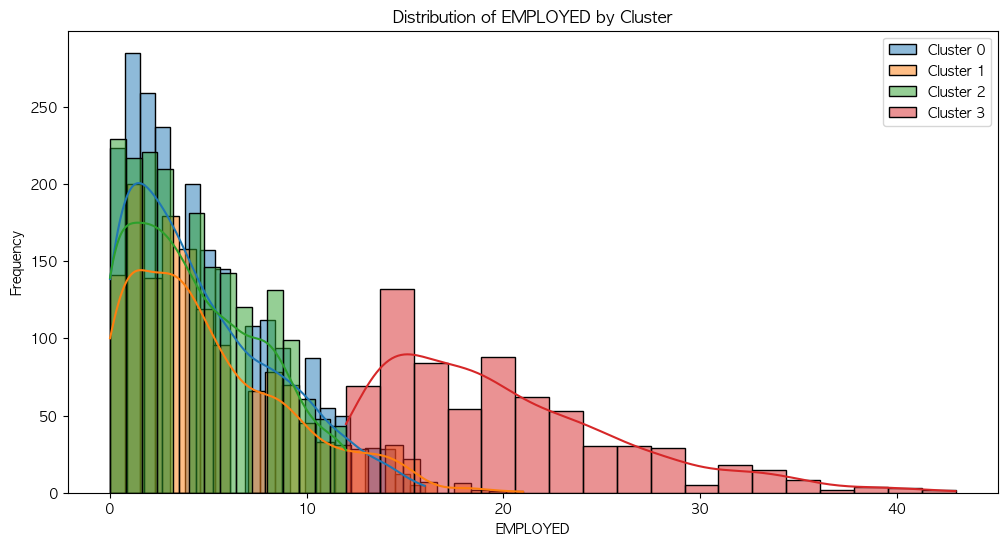

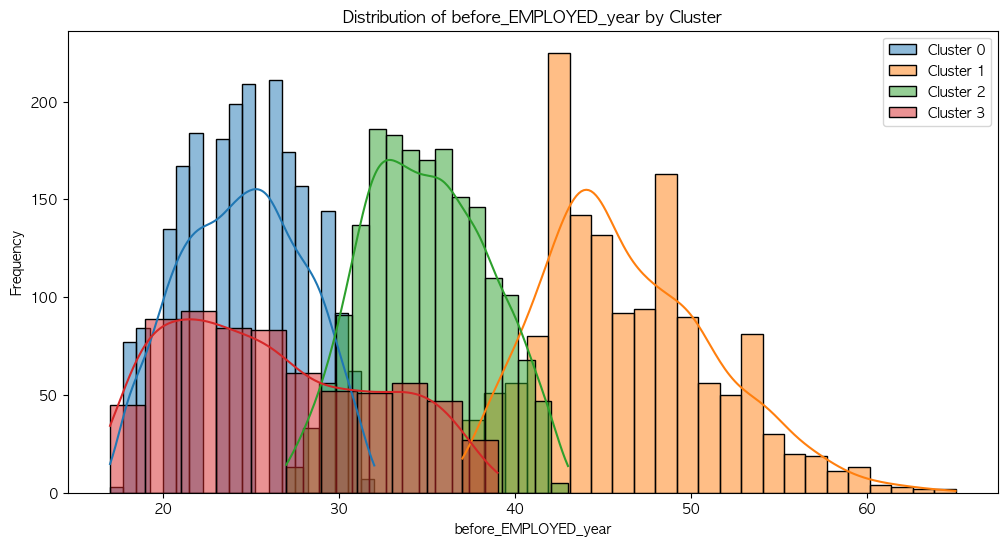

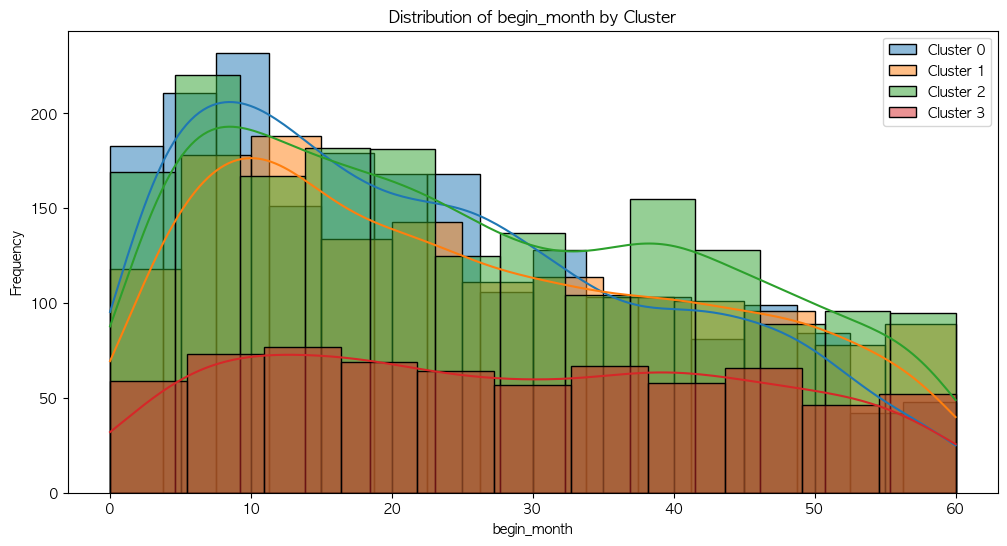

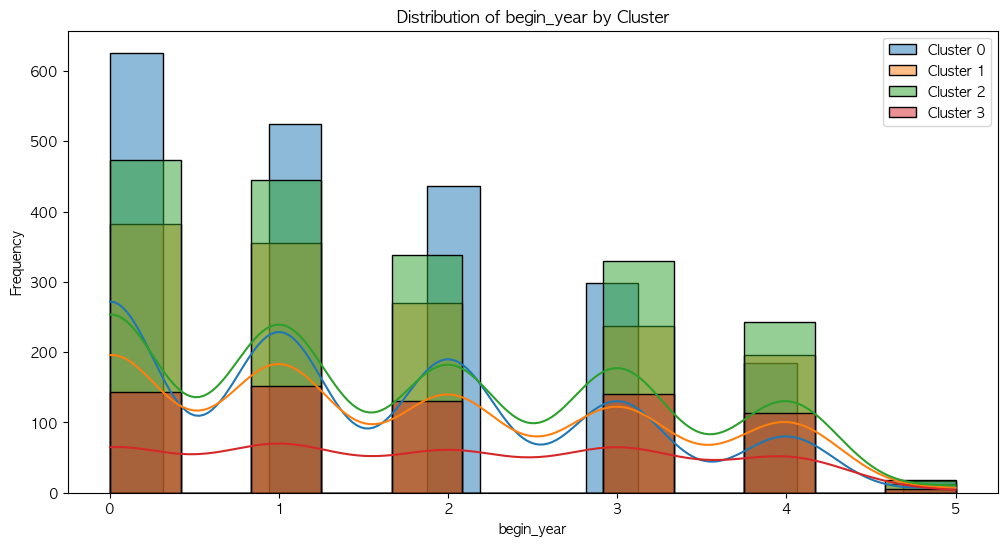

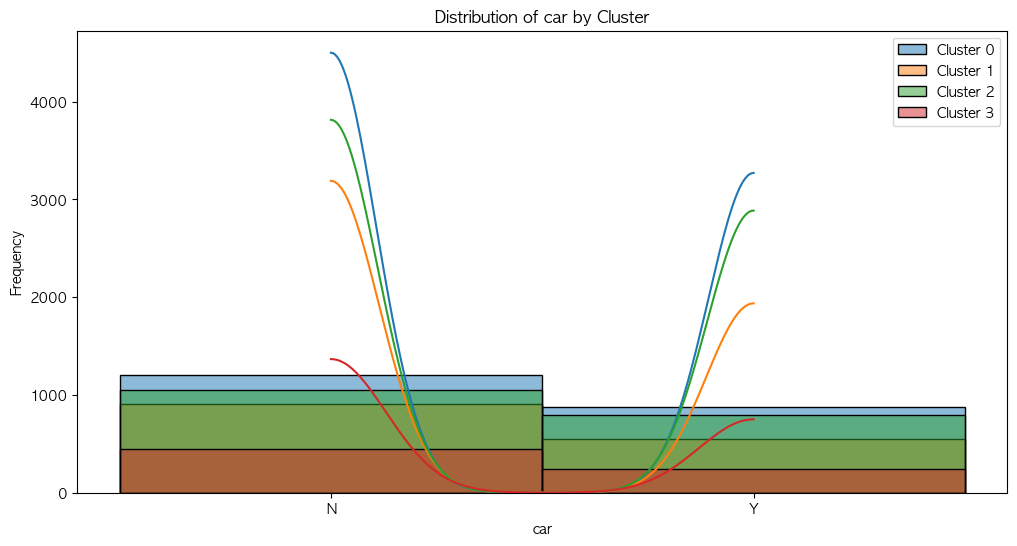

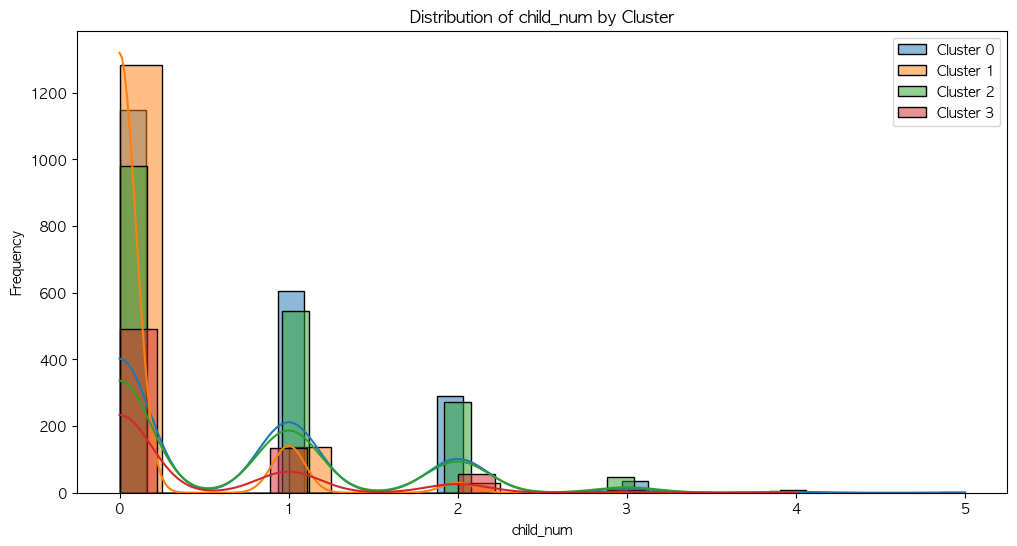

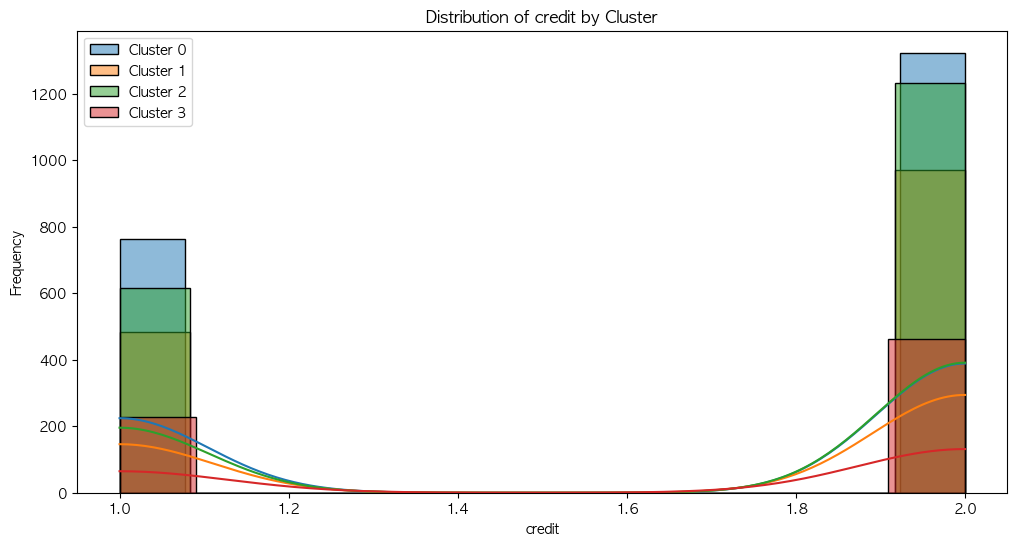

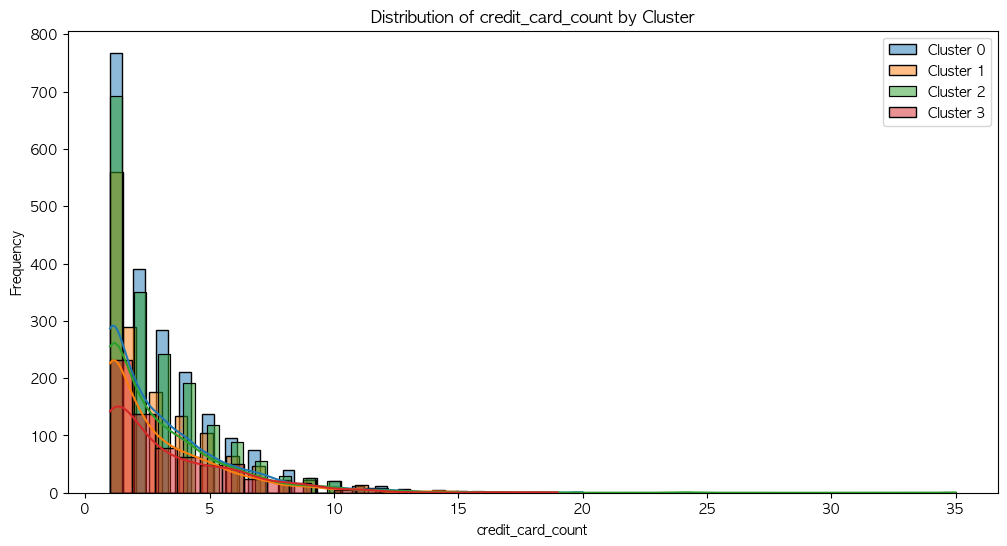

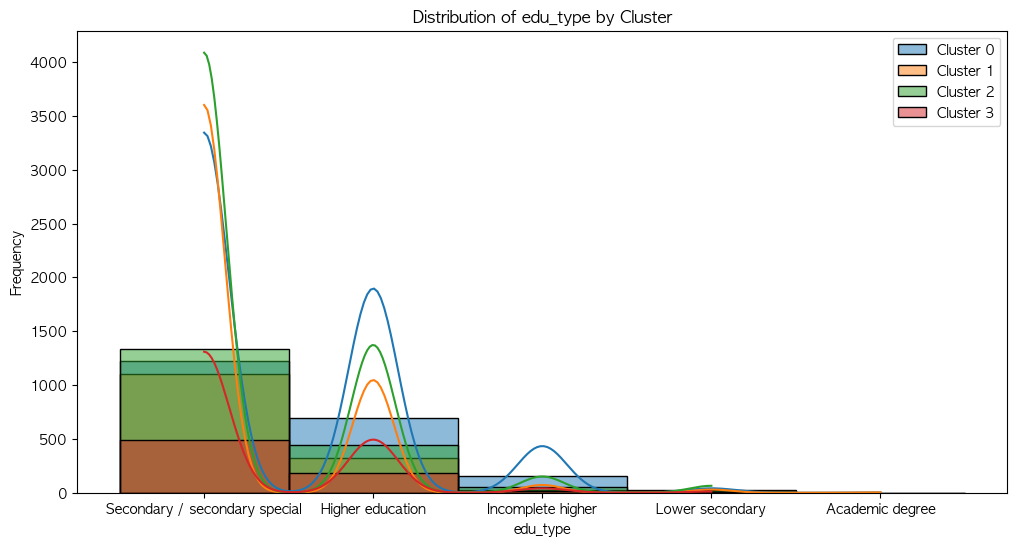

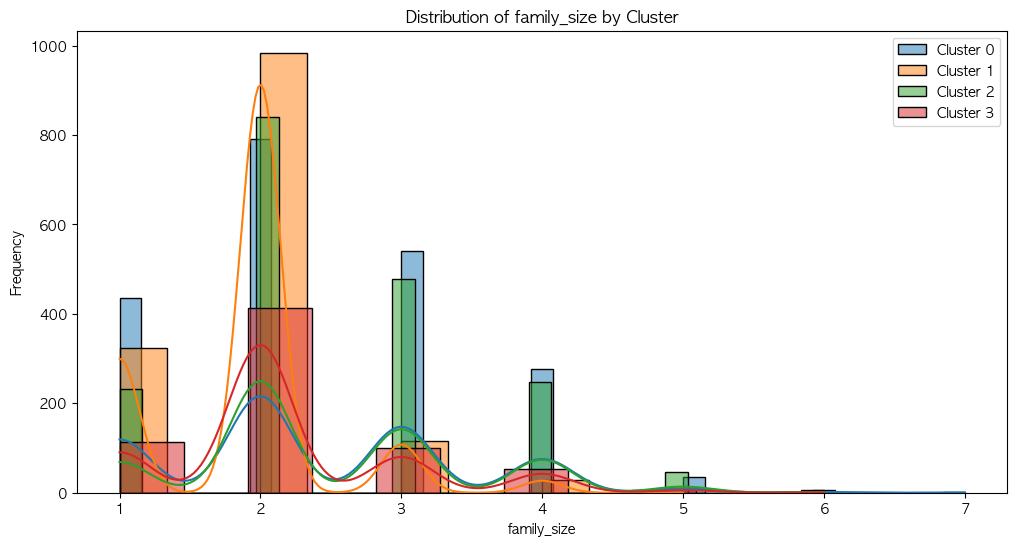

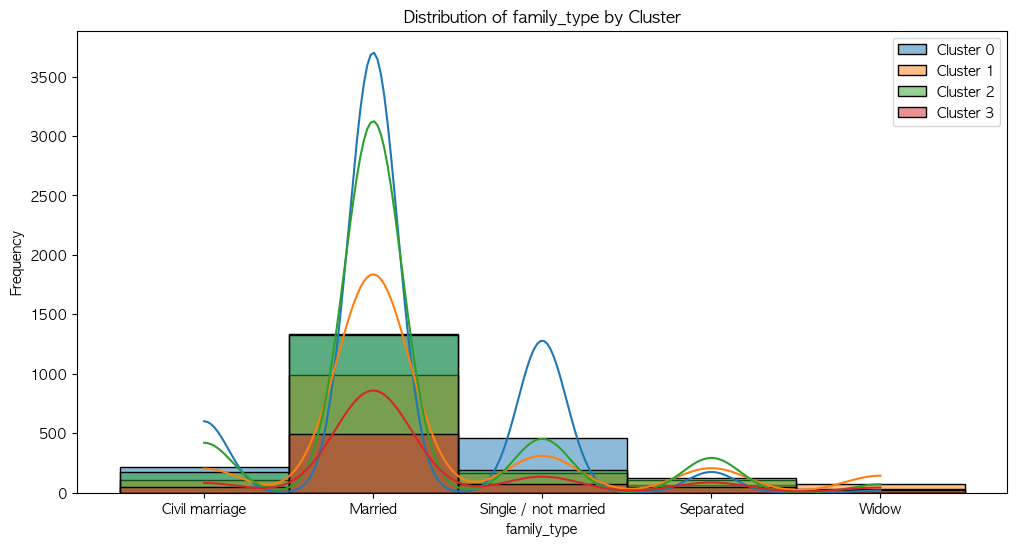

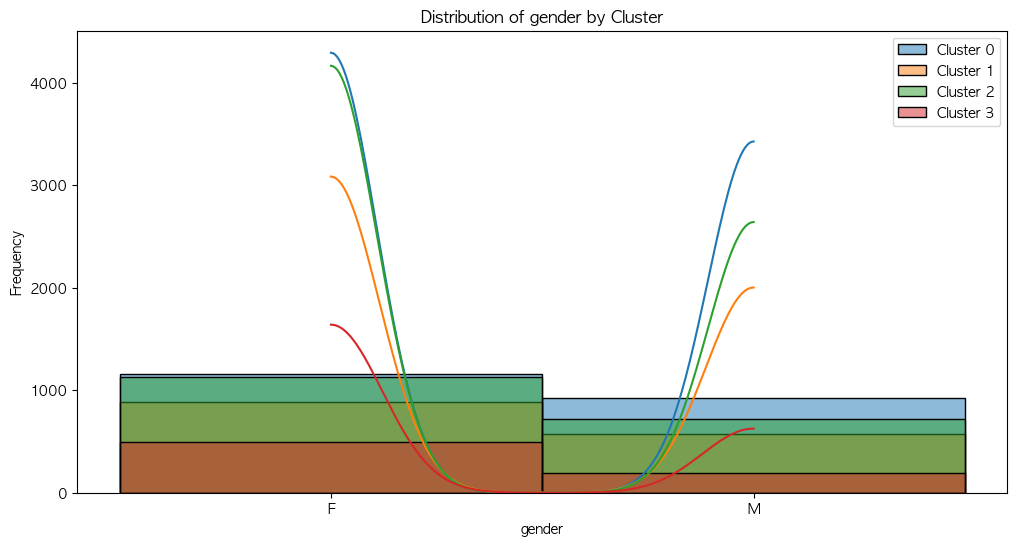

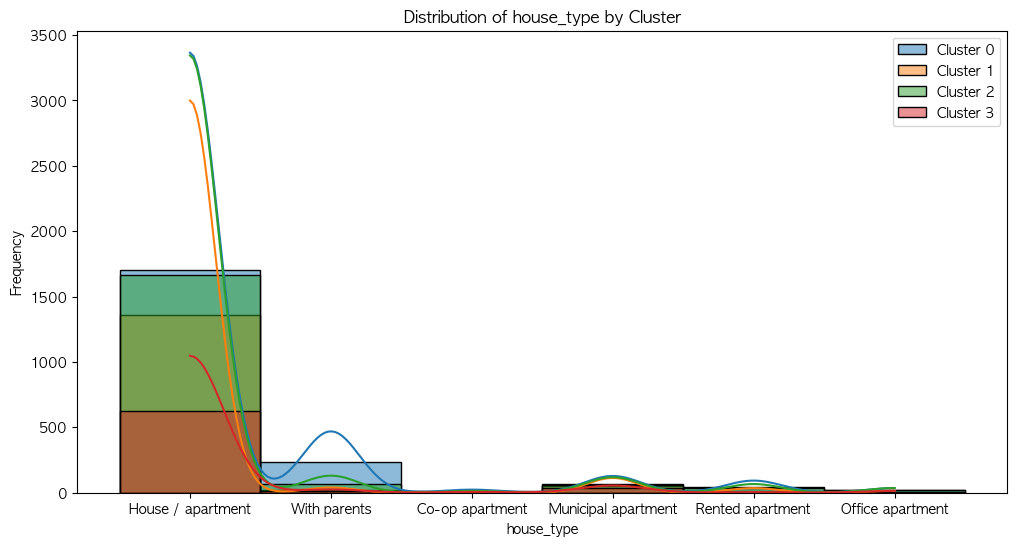

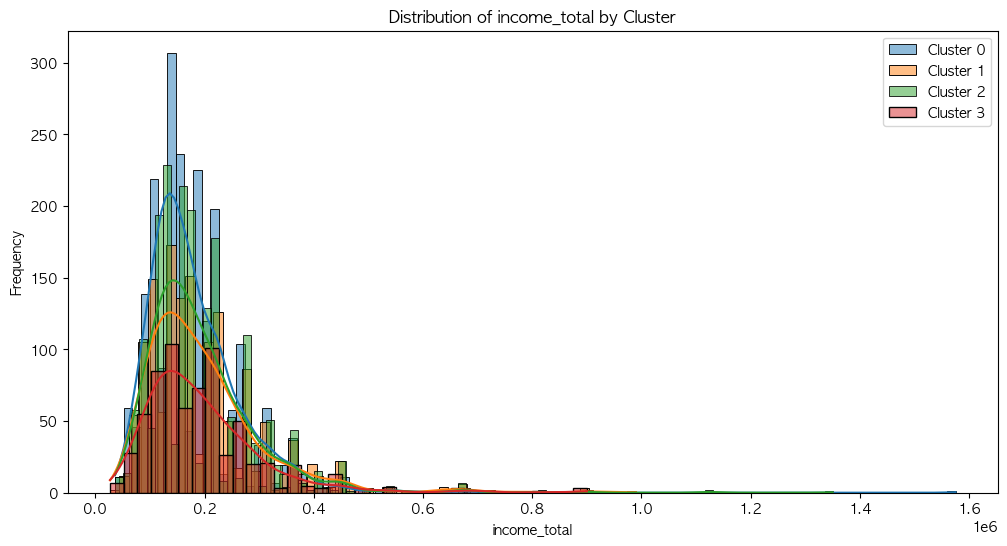

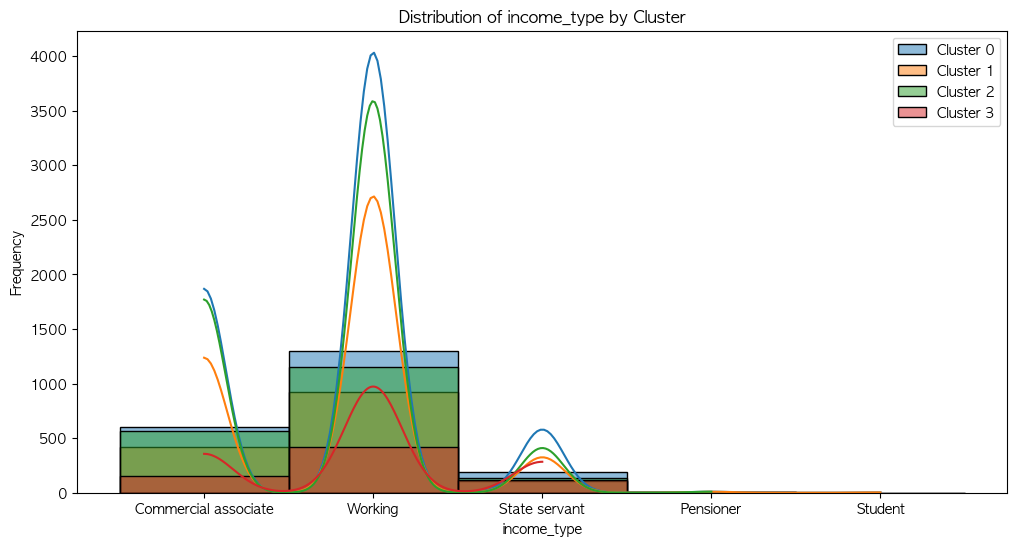

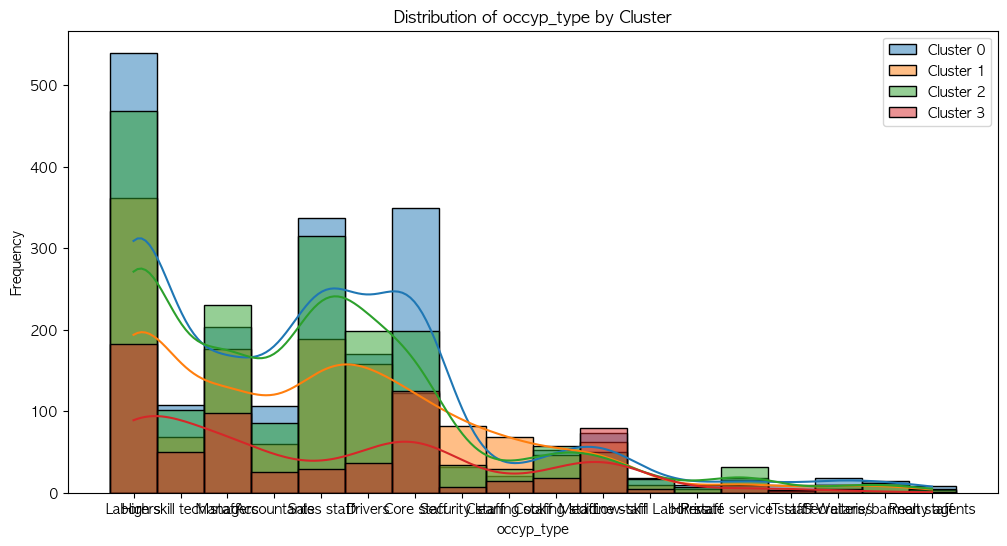

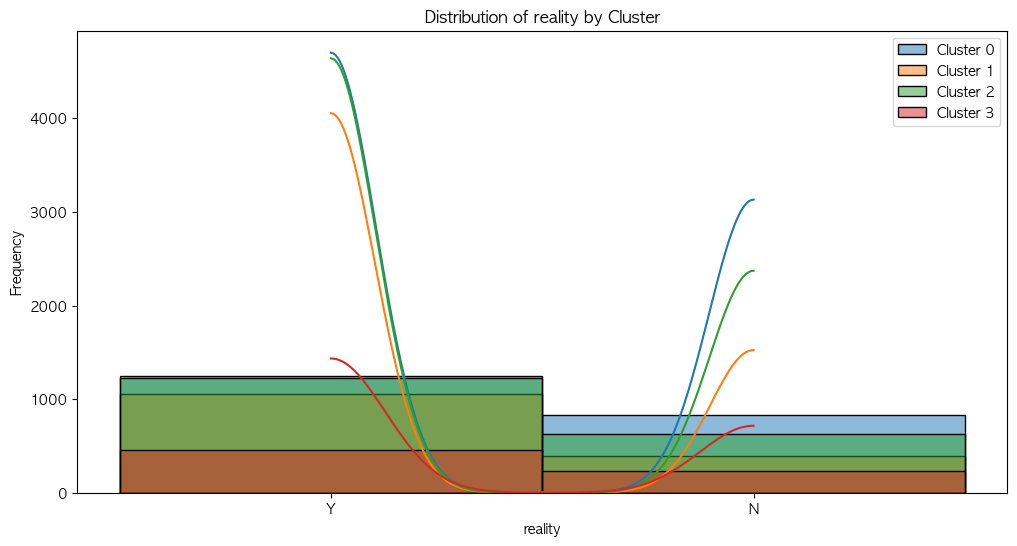

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 'cluster' 변수를 제외한 나머지 변수들의 리스트
variable_list = train_fin.columns.difference(['cluster'])

# 변수들에 대한 히스토그램 그리기
for variable in variable_list:
    plt.figure(figsize=(12, 6))
    for cluster_label in train_fin['cluster'].unique():
        sns.histplot(train_fin[train_fin['cluster'] == cluster_label][variable], label=f'Cluster {cluster_label}', kde=True)

    plt.title(f'Distribution of {variable} by Cluster')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [20]:
train_fin['credit'].value_counts()

2.0    3987
1.0    2088
Name: credit, dtype: int64

In [18]:
train_fin.to_csv('/Users/raekkkky/Desktop/DNA/winter 24/project7/train_fin.csv', index=False)